In [2]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ok.__version__

'1.4.4'

## List Maker (Parallel)

In [29]:
from okama.common import make_asset_list

ls = ['SPY.US', 'AGG.US', 'GC.COMM', 'VOO.US', 'MCFTR.INDX', 'RGBITR.INDX', 'MOW_PR.RE', 'MOW_SEC.RE', 'RUCBTRNS.INDX', 'USDRUB.FX']


In [30]:
make_asset_list.ListMaker._get_asset_obj_dict(ls)

{'SPY.US': symbol                           SPY.US
 name             SPDR S&P 500 ETF Trust
 country                             USA
 exchange                      NYSE ARCA
 currency                            USD
 type                                ETF
 isin                       US78462F1030
 first date                      1993-02
 last date                       2025-02
 period length                     32.00
 dtype: object,
 'AGG.US': symbol                                         AGG.US
 name             iShares Core U.S. Aggregate Bond ETF
 country                                           USA
 exchange                                    NYSE ARCA
 currency                                          USD
 type                                              ETF
 isin                                     US4642872265
 first date                                    2003-10
 last date                                     2025-02
 period length                                   21.40
 dty

In [31]:
al = ok.AssetList(ls, ccy='RUB', inflation=True)
print(al)

assets           [SPY.US, AGG.US, GC.COMM, VOO.US, MCFTR.INDX, ...
currency                                                       RUB
first_date                                                 2010-10
last_date                                                  2024-12
period_length                                   14 years, 3 months
inflation                                                 RUB.INFL
dtype: object


## DCF

In [2]:
assets = ['MCFTR.INDX', 'GC.COMM', 'RGBITR.INDX', 'RUCBTRNS.INDX']
assets1 = ['MCFTR.INDX', 'GC.COMM']
assets2 = ['SPY.US', 'AGG.US', 'GC.COMM']

In [3]:
assets2

['SPY.US', 'AGG.US', 'GC.COMM']

In [4]:
weights = [0.30, 0.55, 0.15]

pf = ok.Portfolio(
    assets2,
    ccy="USD",
    weights=weights,
    inflation=True,
    symbol="retirement_pf.PF",
    rebalancing_period="year",
)
pf

symbol                         retirement_pf.PF
assets                [SPY.US, AGG.US, GC.COMM]
weights                       [0.3, 0.55, 0.15]
rebalancing_period                         year
currency                                    USD
inflation                              USD.INFL
first_date                              2003-10
last_date                               2025-01
period_length                21 years, 4 months
dtype: object

### Indexation Strategy

In [5]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 50_000
ind.amount = 100
ind.frequency = "month"

In [68]:
ind.amount

100

In [6]:
ind.indexation

0.02562697114698298

In [13]:
ind.periods_per_year

12

In [70]:
pf.dcf.cashflow_parameters = ind

In [71]:
pf.dcf.use_discounted_values = False

In [72]:
print(pf.dcf.cashflow_parameters)

Portfolio symbol                retirement_pf.PF
Cash flow initial investment               50000
Cash flow frequency                        month
Cash flow strategy                  fixed_amount
Cash flow amount                             100
Cash flow indexation                     0.02542
dtype: object


In [73]:
pf.dcf.set_mc_parameters(
    distribution="norm",  # Normal distribution (or Gaussian distribution)
    period=10,
    number=100
)

In [76]:
pf.dcf.discount_rate = 0.05

In [82]:
pf.dcf.monte_carlo_wealth_fv.iloc[-1, :]

0    170,719.61028
1    141,593.77819
2    134,723.39262
3    122,297.37464
4    116,157.07966
          ...     
95   110,142.31970
96   141,853.22607
97   110,374.94868
98   110,494.64492
99   137,187.52097
Name: 2034-11, Length: 100, dtype: float64

In [83]:
pf.dcf.monte_carlo_wealth_pv.iloc[-1, :]

0    104,086.18908
1     86,328.43494
2     82,139.62353
3     74,563.59372
4     70,819.91188
          ...     
95    67,152.76760
96    86,486.61795
97    67,294.59936
98    67,367.57707
99    83,641.98010
Name: 2034-11, Length: 100, dtype: float64

In [15]:
pf.dcf.survival_date_hist(threshold=0)

Timestamp('2017-01-31 00:00:00')

In [22]:
pf.dcf.survival_period_hist()

13.3

<Axes: >

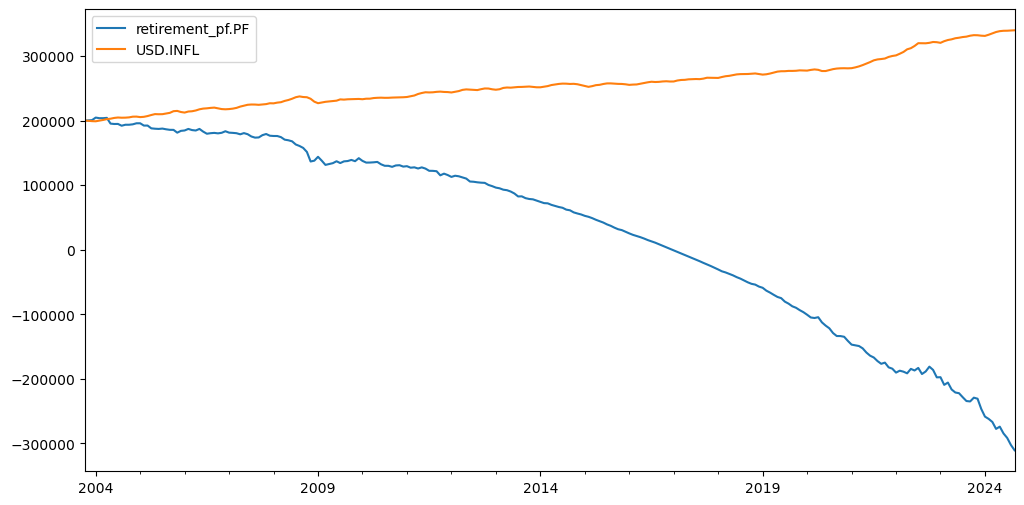

In [21]:
pf.dcf.wealth_index.plot()

In [9]:
# Fixed Percentage strategy
pc = ok.PercentageStrategy(pf)
pc.initial_investment = 10_000
pc.frequency = "year"
pc.percentage = -0.12
pc

Portfolio symbol                portfolio_5530.PF
Cash flow initial investment                10000
Cash flow frequency                          year
Cash flow strategy               fixed_percentage
Cash flow percentage                     -0.12000
dtype: object

In [27]:
# Fixed Amount strategy
ind = ok.IndexationStrategy(portf)
ind.initial_investment = 10_000
# ind.frequency = "year"
# ind.amount = -1500
# ind.indexation = "inflation"
ind

Portfolio symbol                portfolio_7702.PF
Cash flow initial investment                10000
Cash flow frequency                          None
Cash flow strategy                   fixed_amount
Cash flow amount                                0
Cash flow indexation                      0.03081
dtype: object

In [29]:
# TimeSeries strategy
d = {
    "2025-02": 1_000,
    "2029-03": -2_000,
}

d1 = {
    "2018-02": 2_000,
    "2024-03": -4_000,
}

ts = ok.TimeSeriesStrategy(portf)
ts.initial_investment = 1_000
ts.time_series_dic = d1

ts

Portfolio symbol                portfolio_7702.PF
Cash flow initial investment                 1000
Cash flow strategy                    time_series
dtype: object

In [19]:
# Assign a strategy
pf.dcf.cashflow_parameters = pc
# pf.dcf.discount_rate = 0.10
# pf.dcf.use_discounted_values = False

In [23]:
pf.dcf

Portfolio symbol            portfolio_2953.PF
Monte carlo distribution                 norm
Monte carlo period                         25
Cash flow strategy           fixed_percentage
use_discounted_values                   False
dtype: object

In [8]:
# Set Monte Carlo
pf.dcf.set_mc_parameters(distribution="t", period=10, number=100)

In [14]:
pf.dcf.mc.period = 10

In [9]:
pf.dcf.mc.period

14

In [22]:
pf.dcf.cash_flow_parameters

AttributeError: 'PortfolioDCF' object has no attribute 'cash_flow_parameters'

In [20]:
pf.dcf.initial_investment_fv

<Axes: xlabel='date'>

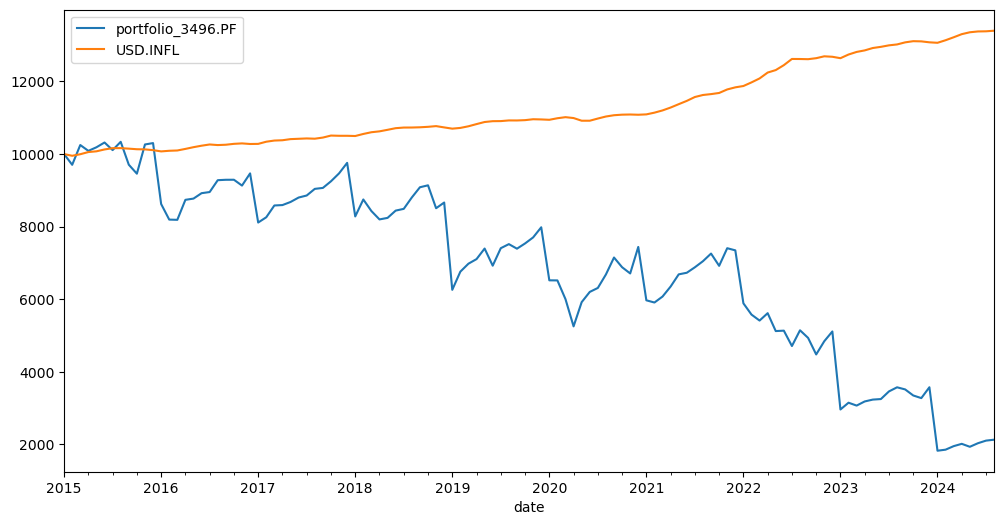

In [96]:
pf.dcf.wealth_index.plot()

In [9]:
df = pf.dcf.monte_carlo_wealth_pv

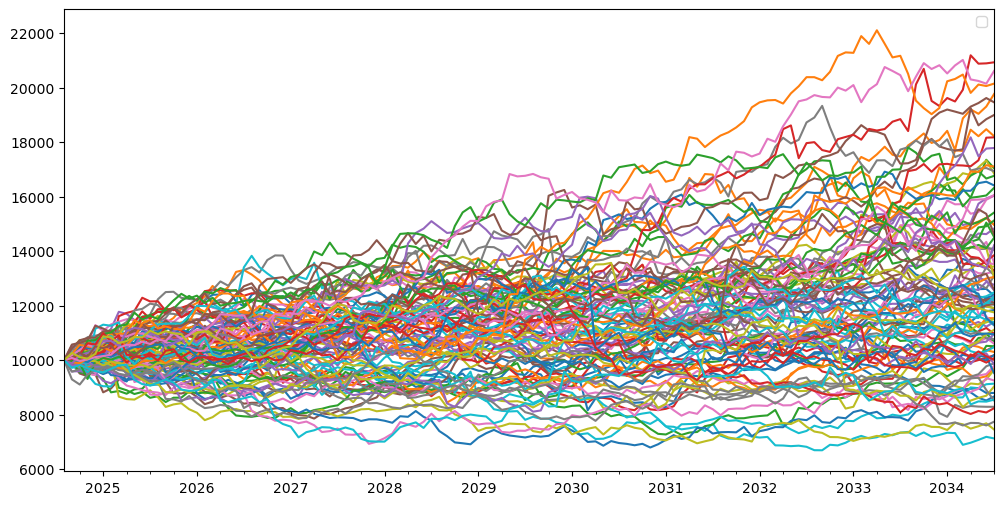

In [11]:
df.plot()
plt.legend("")

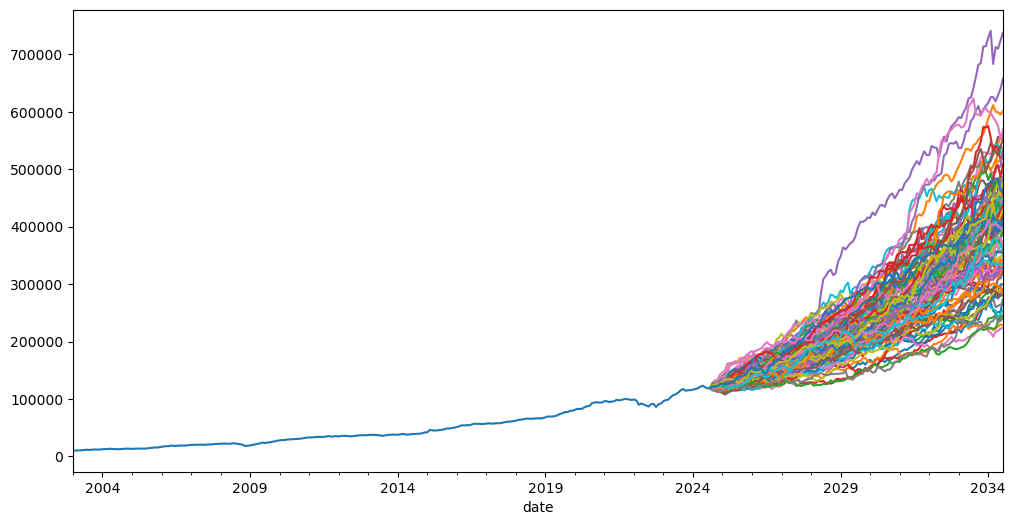

In [13]:
pf.dcf.plot_forecast_monte_carlo(backtest=True)

### find_the_largest_withdrawals_size

In [3]:
assets = ['RGBITR.INDX', 'RUCBTRNS.INDX', 'MCFTR.INDX', 'GC.COMM']
weights = [0.16,          0.40,             0.25,        0.19]
pf = ok.Portfolio(assets, weights=weights, ccy='RUB', rebalancing_period='year', inflation=False)
pf.dcf.discount_rate = 0.09
print(pf)

symbol                                                portfolio_9596.PF
assets                [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                         [0.16, 0.4, 0.25, 0.19]
rebalancing_period                                                 year
currency                                                            RUB
inflation                                                          None
first_date                                                      2003-01
last_date                                                       2025-03
period_length                                        22 years, 3 months
dtype: object


In [4]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 2_000_000 * 90
ind.amount = -4000 * 90
ind.frequency = "month"
ind.indexation = 0.09

pf.dcf.cashflow_parameters = ind
print(ind)

Portfolio symbol                portfolio_9596.PF
Cash flow initial investment            180000000
Cash flow frequency                         month
Cash flow strategy                   fixed_amount
Cash flow amount                          -360000
Cash flow indexation                      0.09000
dtype: object


In [5]:
ind.amount * 12 / ind.initial_investment * 100

-2.4

In [6]:
pf.dcf.mc.period = 50
pf.dcf.mc.number = 100
pf.dcf.mc.distribution = "norm"

In [7]:
pf.dcf.monte_carlo_survival_period().describe()

count   100.00000
mean     49.03200
std       3.33584
min      32.20000
25%      50.00000
50%      50.00000
75%      50.00000
max      50.00000
dtype: float64

In [8]:
mc_wealth_pv = pf.dcf.monte_carlo_wealth_pv

In [9]:
mc50years_wealth_pv = mc_wealth_pv.iloc[-1, :]
mc50years_wealth_pv.describe([0.05, 0.20, 0.30, 0.50])

count              90.00000
mean      400,707,166.39629
std       331,212,582.94797
min         8,107,953.18626
5%         39,702,834.57472
20%       143,359,085.40553
30%       200,303,716.07043
50%       308,283,047.77550
max     1,797,835,507.07551
Name: 2075-02, dtype: float64

In [11]:
pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv",
    percentile=20,
    tolerance_rel=0.10,
)

[autoreload of pydevd failed: Traceback (most recent call last):
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 365, in update_class
    update_instances(old, new)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
    
TypeError: __class__ assignment: 'ThreadsSuspendedSingleNotification' object layout differs from 'ThreadsSuspendedSi

207278783.98273996 -270000.0
error_rel=0.152, gradient=0.000
increasing withdrawal
0.0 -90405000.0
error_rel=1.000, gradient=0.848
decreasing withdrawal


KeyboardInterrupt: 

## Rolling and expanding risk

In [13]:
al = ok.AssetList(["SPY.US", "BND.US"])
al

assets             [SPY.US, BND.US]
currency                        USD
first_date                  2007-05
last_date                   2024-01
period_length    16 years, 9 months
inflation                  USD.INFL
dtype: object

<Axes: xlabel='date'>

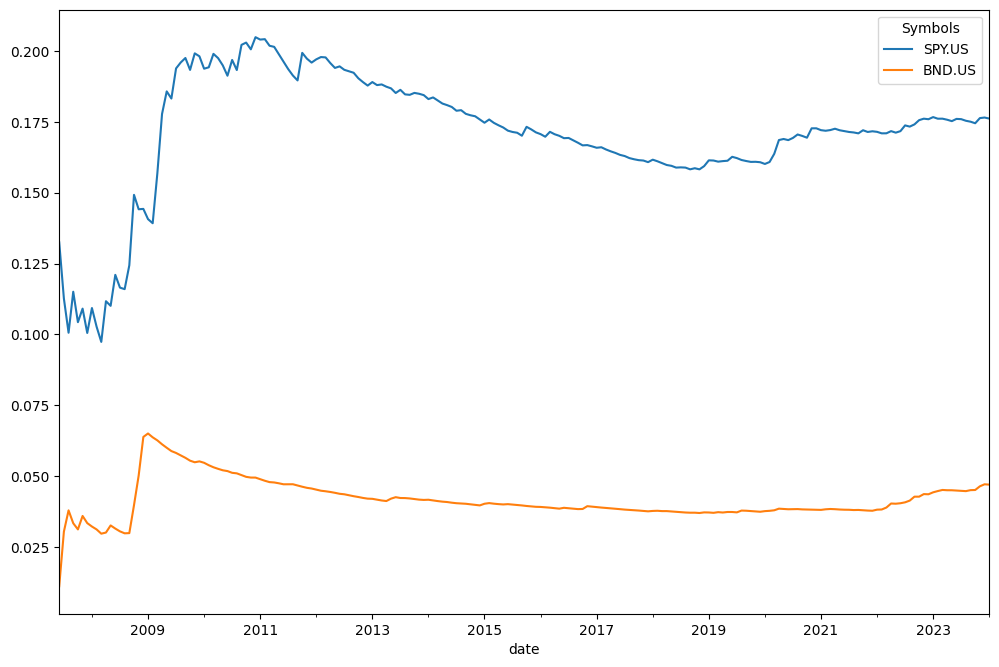

In [9]:
al.risk_annual.plot()

<Axes: xlabel='date'>

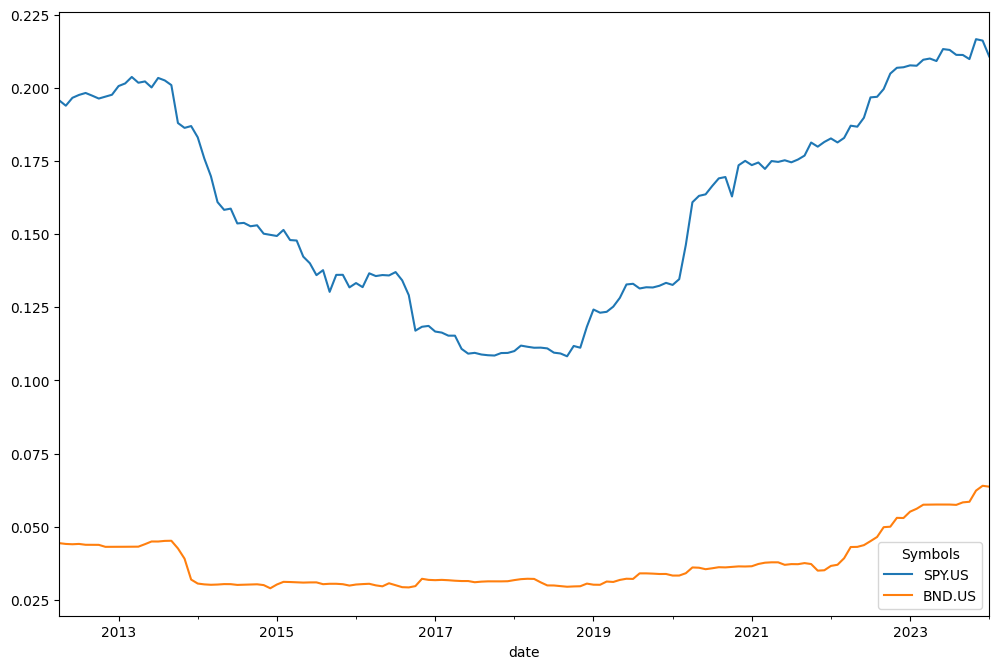

In [10]:
al.get_rolling_risk_annual(window=12 * 5).plot()

In [14]:
al.describe()

C:\Users\Sergey\PycharmProjects\okama\okama\asset.py:175: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  return div.resample("M").sum()
C:\Users\Sergey\PycharmProjects\okama\okama\asset.py:175: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  return div.resample("M").sum()


,property,period,SPY.US,BND.US,inflation
0,Compound return,YTD,0.01590,-0.00160,0.00540
1,CAGR,1 years,0.20603,0.02105,0.03089
2,CAGR,5 years,0.14194,0.00782,0.04148
3,CAGR,10 years,0.12509,0.01565,0.02805
4,CAGR,"16 years, 9 months",0.09404,0.02918,0.02419
5,Annualized mean return,"16 years, 9 months",0.10801,0.03024,NaN
6,Dividend yield,LTM,0.01374,0.03090,NaN
7,Risk,"16 years, 9 months",0.17617,0.04695,NaN
8,CVAR,"16 years, 9 months",0.40832,0.15194,NaN
9,Max drawdowns,"16 years, 9 months",-0.50780,-0.17534,NaN


## Dividends

In [5]:
al = ok.AssetList(["SBERP.MOEX", "LKOH.MOEX"], ccy="RUB")
al

assets           [SBERP.MOEX, LKOH.MOEX]
currency                             RUB
first_date                       2006-09
last_date                        2023-12
period_length         17 years, 4 months
inflation                       RUB.INFL
dtype: object

In [6]:
al.dividends_annual

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.46500,38.00000
2008,0.65000,42.00000
2009,0.63000,50.00000
2010,0.45000,52.00000
2011,1.15000,59.00000
2012,2.59000,115.00000
2013,3.20000,100.00000
2014,3.20000,120.00000
2015,0.45000,159.00000


In [8]:
al.dividend_yield

,SBERP.MOEX,LKOH.MOEX
2006-09,0.00000,0.00000
2006-10,0.00000,0.00000
2006-11,0.00000,0.00000
2006-12,0.00000,0.00000
2007-01,0.00000,0.00000
...,...,...
2023-08,0.09425,0.22437
2023-09,0.09580,0.22950
2023-10,0.09320,0.21406
2023-11,0.09058,0.21095


In [9]:
al.dividend_yield_annual

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.00667,0.01834
2008,0.07174,0.04368
2009,0.00913,0.02952
2010,0.00599,0.02985
2011,0.01943,0.03469
2012,0.03848,0.05749
2013,0.03999,0.04902
2014,0.08488,0.05393
2015,0.00588,0.06778


In [11]:
al.dividend_yield.resample(rule="Y").last()

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.00667,0.01834
2008,0.07174,0.04368
2009,0.00913,0.02952
2010,0.00599,0.02985
2011,0.01943,0.03469
2012,0.03848,0.05749
2013,0.03999,0.04902
2014,0.08488,0.05393
2015,0.00588,0.06778


<Axes: >

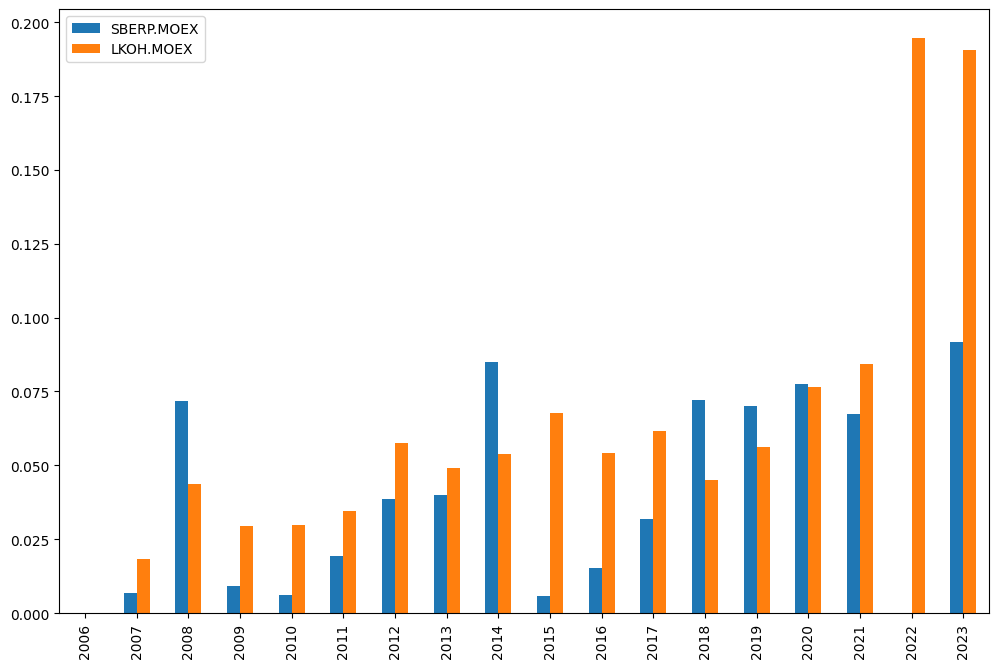

In [12]:
al.dividend_yield_annual.plot(kind="bar")

In [13]:
al.get_dividend_mean_growth_rate()

SBERP.MOEX   -1.00000
LKOH.MOEX     0.28652
dtype: float64

In [14]:
al.get_dividend_mean_yield(10)

SBERP.MOEX   0.05166
LKOH.MOEX    0.08849
dtype: float64

## Plot Wealth

In [15]:
def plot_wealth(
    al: object,
    first_date: str,
    last_date: str,
    legend: list,
    title: str = None,
    logy: bool = False,
    figsize: list = [12, 10],
):
    fig, ax = plt.subplots(figsize=figsize)
    # fig.subplots_adjust(bottom=0.2, top=1.5)
    first_date_dt = pd.to_datetime(first_date)
    last_date_dt = pd.to_datetime(last_date)

    wealth = al.wealth_indexes
    wealth = wealth.loc[first_date:last_date, :]
    index = wealth.index.to_timestamp()
    min_value = wealth.to_numpy().min()
    for i, asset in enumerate(wealth):
        if i == len(wealth.columns) - 1:
            # Inflation is in the last column
            continue
        ax.plot(index, wealth[asset], linewidth=2)
    ax.fill_between(index, min_value, wealth.iloc[:, -1], facecolor="grey", alpha=0.2, label="Инфляция")

    # Log scale
    y_scale = "log" if logy else "linear"
    ax.set_yscale(y_scale)

    # границы графика
    ax.set_xlim(first_date_dt, last_date_dt + pd.DateOffset(months=0))
    ax.set_ylim(bottom=min_value)

    # регулирования надписей оси Х
    years = mdates.YearLocator()  # ежегодный формат
    years_fmt = mdates.DateFormatter("%Y")
    # назначение формата надписей
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    ax.legend(legend + ["Инфляция"], loc="upper left")
    ax.set_title(title)

    # ax.set_ylabel('Инфляция за 12 месяцев, %')

In [16]:
stocks = ok.AssetList(["MCFTR.INDX", "SP500TR.INDX"], ccy="RUB", inflation=False)
stocks

assets           [MCFTR.INDX, SP500TR.INDX]
currency                                RUB
first_date                          1997-10
last_date                           2024-02
period_length            26 years, 5 months
inflation                              None
dtype: object

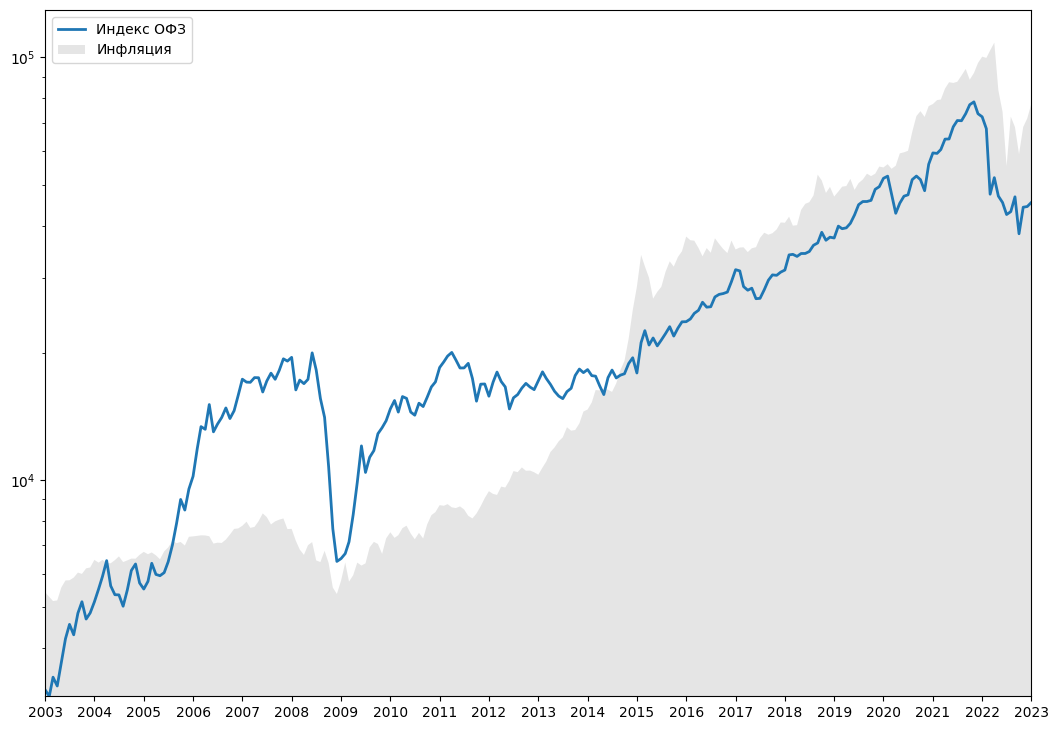

In [17]:
plot_wealth(
    al=stocks, first_date="2003-01", figsize=(14 / 1.1, 10 / 1.1), last_date="2023-01", legend=["Индекс ОФЗ"], logy=True
)

## Efficiency frontier

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Convex function

2025-04-08 23:27:12,724 - INFO - left EF point #1/10 is done in 0.27 sec.
2025-04-08 23:27:13,109 - INFO - left EF point #2/10 is done in 0.63 sec.
2025-04-08 23:27:13,616 - INFO - left EF point #3/10 is done in 0.84 sec.
2025-04-08 23:27:13,968 - INFO - left EF point #4/10 is done in 0.79 sec.
2025-04-08 23:27:14,403 - INFO - left EF point #5/10 is done in 0.78 sec.
2025-04-08 23:27:14,844 - INFO - left EF point #6/10 is done in 0.87 sec.
2025-04-08 23:27:15,283 - INFO - left EF point #7/10 is done in 0.88 sec.
2025-04-08 23:27:15,717 - INFO - left EF point #8/10 is done in 0.87 sec.
2025-04-08 23:27:16,082 - INFO - left EF point #9/10 is done in 0.80 sec.
2025-04-08 23:27:17,190 - INFO - left EF point #10/10 is done in 1.47 sec.
2025-04-08 23:27:20,537 - INFO - right EF point #1/8 is done in 2.24 sec.
2025-04-08 23:27:20,590 - INFO - right EF point #2/8 is done in 2.29 sec.
2025-04-08 23:27:22,610 - INFO - right EF point #3/8 is done in 2.07 sec.
2025-04-08 23:27:22,657 - INFO - righ

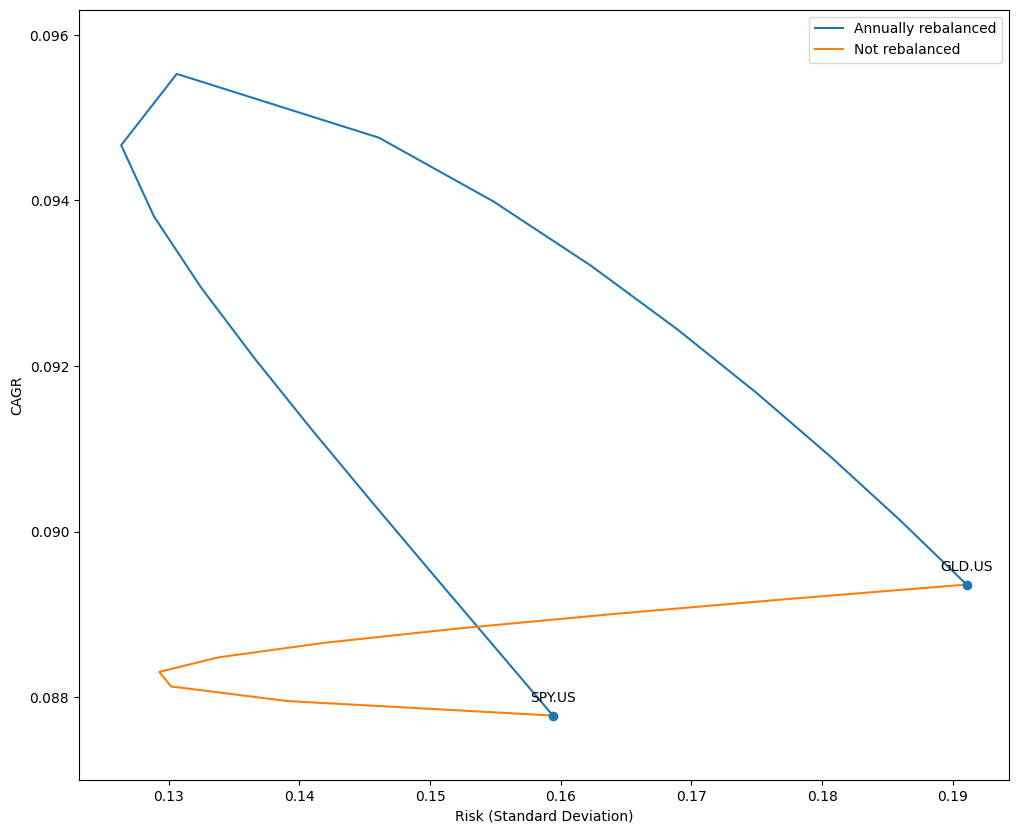

In [7]:
ls = ["SPY.US", "GLD.US"]
curr = "USD"
y = ok.EfficientFrontierReb(
    assets=ls,
    first_date="2004-12",
    last_date="2020-10",
    ccy=curr,
    rebalancing_period="year",  # set rebalancing period to one year
    ticker_names=True,  # use tickers in DataFrame column names (can be set to False to show full assets names instead tickers)
    n_points=10,  # number of points in the Efficient Frontier
    verbose=True,
)  # verbose mode is ON to show progress while the EF points are calcualted

df_reb_year = y.ef_points

y.rebalancing_period = "none"

df_not_reb = y.ef_points

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the Efficient Fronrier
ax.plot(df_reb_year.Risk, df_reb_year.CAGR, label="Annually rebalanced")
ax.plot(df_not_reb.Risk, df_not_reb.CAGR, label="Not rebalanced")

# Plot the aseets
y.plot_assets(kind="cagr")

# Set axis labels
ax.set_xlabel("Risk (Standard Deviation)")
ax.set_ylabel("CAGR")
ax.legend();

### Non-convex function

2025-04-08 23:29:52,099 - INFO - left EF point #1/10 is done in 0.98 sec.
2025-04-08 23:29:54,989 - INFO - left EF point #3/10 is done in 2.89 sec.
2025-04-08 23:29:55,154 - INFO - left EF point #2/10 is done in 4.03 sec.
2025-04-08 23:29:57,475 - INFO - left EF point #4/10 is done in 2.48 sec.
2025-04-08 23:29:57,901 - INFO - left EF point #5/10 is done in 2.74 sec.
2025-04-08 23:30:00,262 - INFO - left EF point #6/10 is done in 2.78 sec.
2025-04-08 23:30:00,532 - INFO - left EF point #7/10 is done in 2.62 sec.
2025-04-08 23:30:02,930 - INFO - left EF point #8/10 is done in 2.67 sec.
2025-04-08 23:30:03,753 - INFO - left EF point #9/10 is done in 3.22 sec.
2025-04-08 23:30:09,071 - INFO - left EF point #10/10 is done in 6.14 sec.
2025-04-08 23:30:21,490 - INFO - right EF point #2/3 is done in 6.95 sec.
2025-04-08 23:30:21,689 - INFO - right EF point #1/3 is done in 7.15 sec.
2025-04-08 23:30:25,219 - INFO - right EF point #3/3 is done in 3.72 sec.
2025-04-08 23:30:25,231 - INFO - Tota

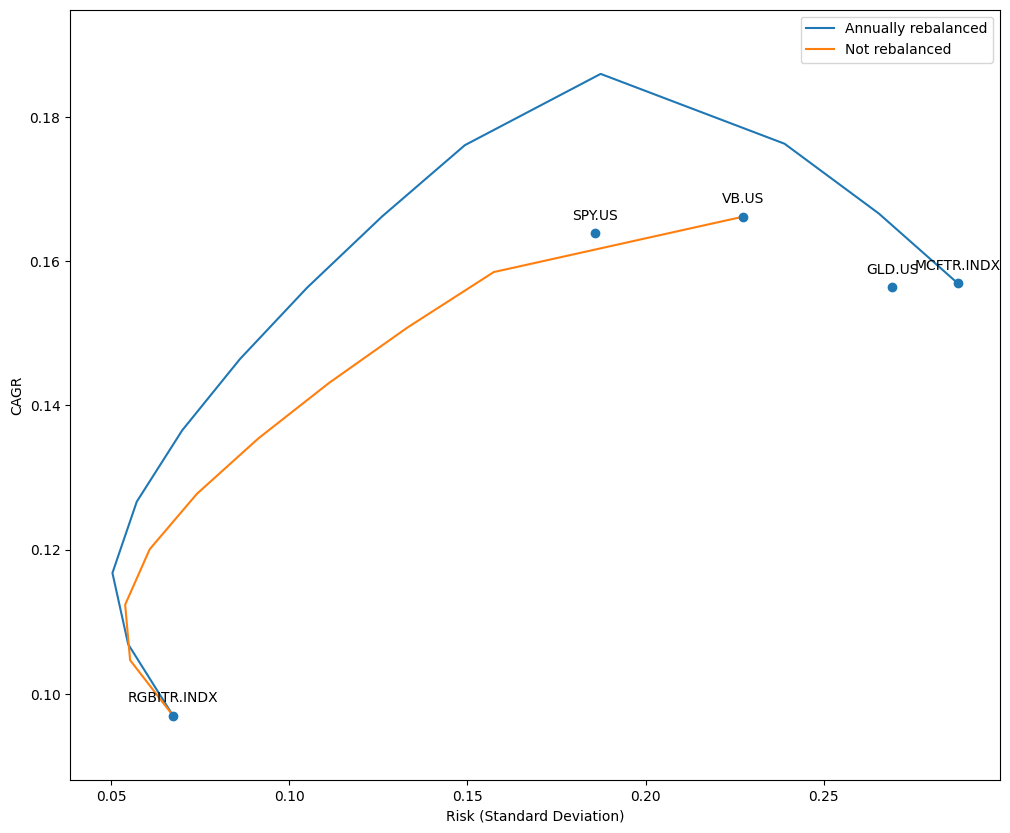

In [8]:
ls_m = ["SPY.US", "GLD.US", "VB.US", "RGBITR.INDX", "MCFTR.INDX"]
curr_rub = "RUB"

x = ok.EfficientFrontierReb(
    assets=ls_m,
    first_date="2004-12",
    last_date="2020-12",
    ccy=curr_rub,
    rebalancing_period="year",  # set rebalancing period to one year
    n_points=10,
    verbose=True,
)

df1_reb_year = x.ef_points

x.rebalancing_period = "none"

df1_not_reb = x.ef_points

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the Efficient Frontiers
ax.plot(df1_reb_year.Risk, df1_reb_year.CAGR, label="Annually rebalanced")
ax.plot(df1_not_reb.Risk, df1_not_reb.CAGR, label="Not rebalanced")

# Plot the assets
x.plot_assets(kind="cagr")

# Set labels
ax.set_xlabel("Risk (Standard Deviation)")
ax.set_ylabel("CAGR")
ax.legend();

## Different bounds

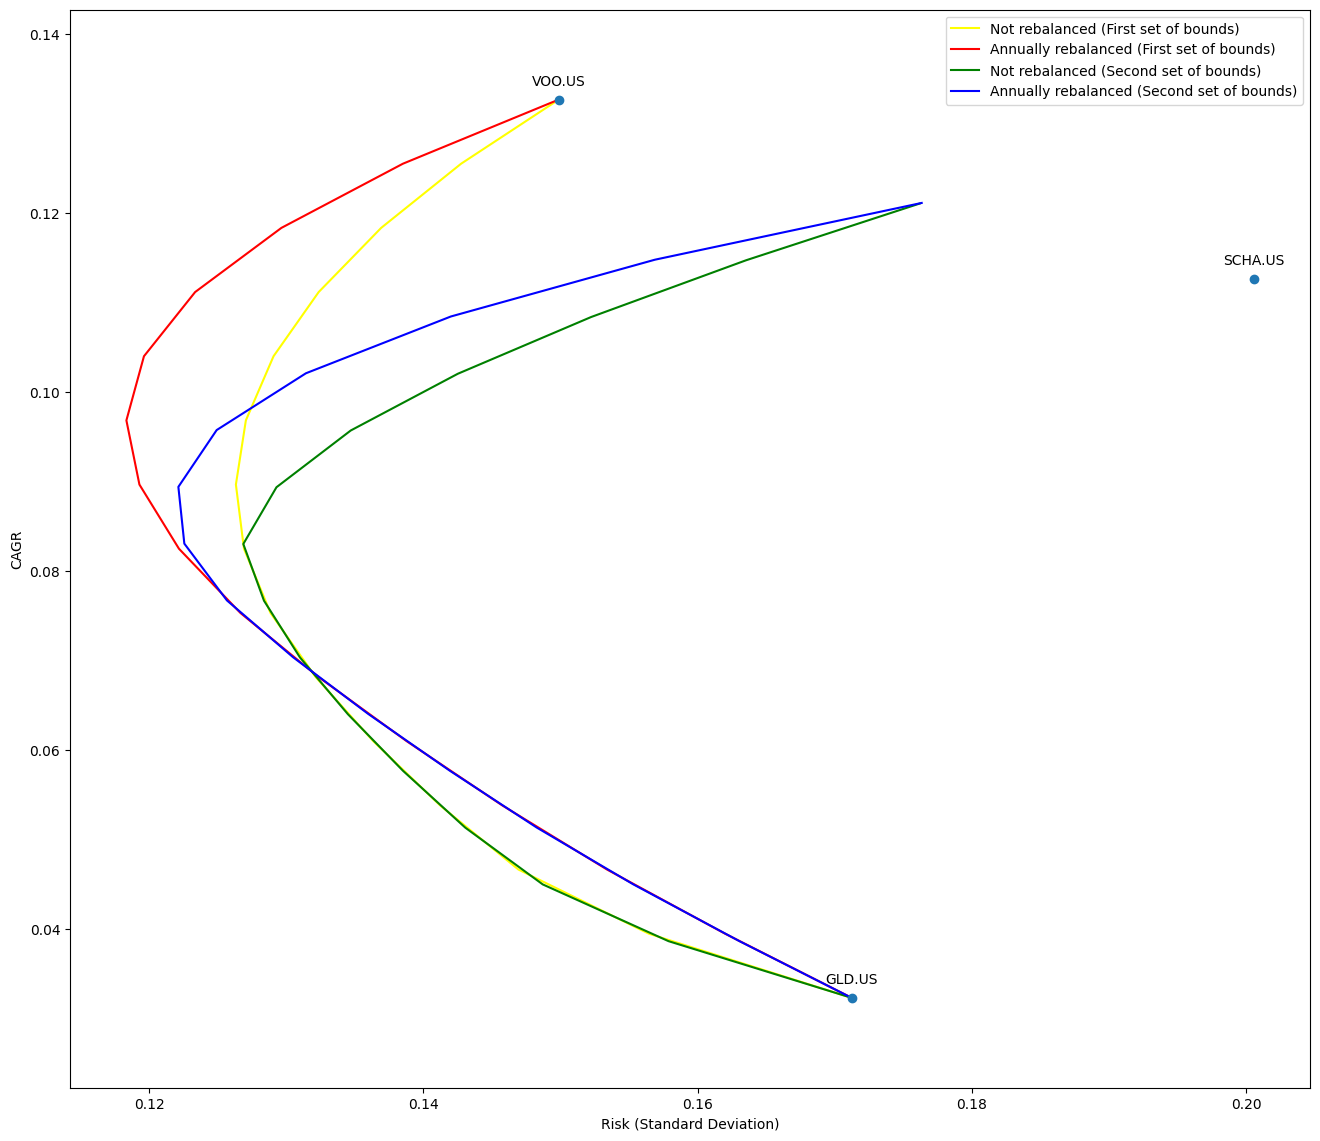

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

ls_m = ["VOO.US", "GLD.US", "SCHA.US"]
curr_rub = "USD"

x = ok.EfficientFrontierReb(
    assets=ls_m,
    first_date="2004-10",
    last_date="2020-10",
    ccy=curr_rub,
    n_points=15,
    bounds=((0, 1), (0, 1), (0, 1)),  # add bounds
    verbose=False,
)

x.rebalancing_period = "none"
df1_not_reb = x.ef_points

x.rebalancing_period = "year"
df1_reb_year = x.ef_points


y = ok.EfficientFrontierReb(
    assets=ls_m,
    first_date="2004-10",
    last_date="2020-10",
    ccy=curr_rub,
    n_points=15,
    bounds=((0, 0.4), (0, 1), (0, 1)),  # add bounds
    verbose=False,
)

y.rebalancing_period = "none"
df2_not_reb = y.ef_points

y.rebalancing_period = "year"
df2_reb_year = y.ef_points

fig, ax = plt.subplots(figsize=(16, 14))

# Plot not rebalanced frontier for x
ax.plot(df1_not_reb.Risk, df1_not_reb.CAGR, label="Not rebalanced (First set of bounds)", color="yellow")

# Plot yearly rebalanced frontier for x
ax.plot(df1_reb_year.Risk, df1_reb_year.CAGR, label="Annually rebalanced (First set of bounds)", color="red")

# Plot not rebalanced frontier for y
ax.plot(df2_not_reb.Risk, df2_not_reb.CAGR, label="Not rebalanced (Second set of bounds)", color="green")

# Plot yearly rebalanced frontier for y
ax.plot(df2_reb_year.Risk, df2_reb_year.CAGR, label="Annually rebalanced (Second set of bounds)", color="blue")

# Plot the assets
x.plot_assets(kind="cagr")

# Set axis labels
ax.set_xlabel("Risk (Standard Deviation)")
ax.set_ylabel("CAGR")
ax.legend()
plt.show()

## Plot Pair Efficient Frontier for different periods

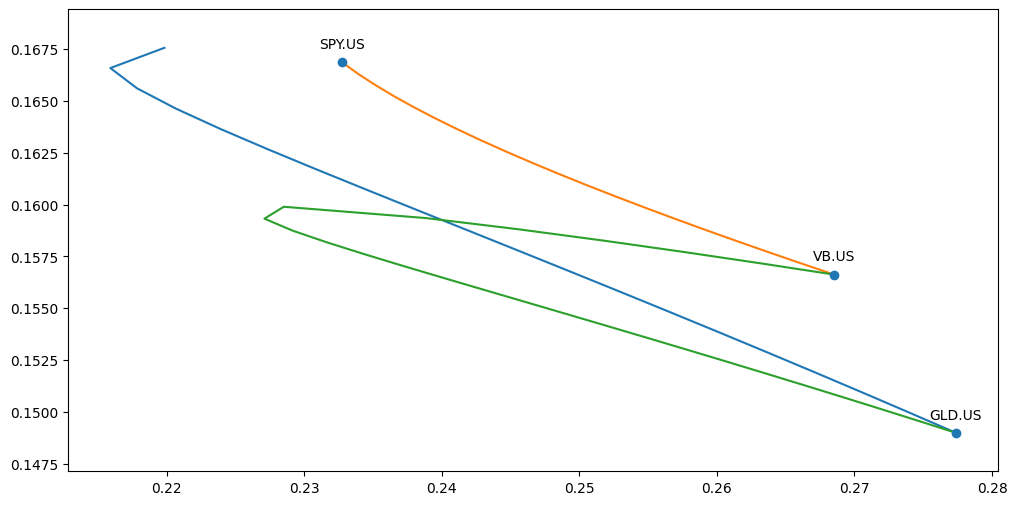

In [3]:
pf = ["SPY.US", "GLD.US", "VB.US"]

curr = 'RUB'

last_date="2024-07"

bounds=((0, 1), (0, 1), (0, 1))

ef = ok.EfficientFrontierReb(pf, ccy=curr, last_date=last_date, bounds=bounds)

ef.plot_pair_ef()

plt.show()

## Monte Carlo simulation

### Default bounds

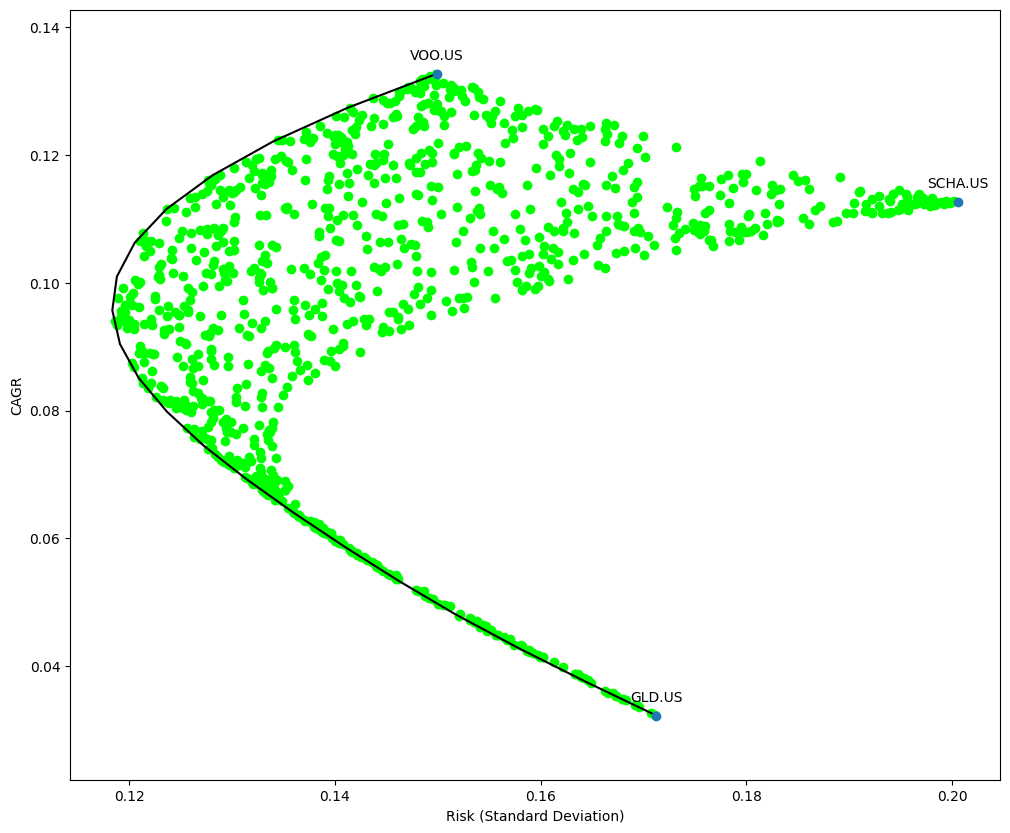

In [3]:
assets = ["VOO.US", "GLD.US", "SCHA.US"]
curr = "USD"

x_1 = ok.EfficientFrontierReb(
    assets=assets,
    first_date="2004-10",
    last_date="2020-10",
    ccy=curr,
    verbose=False,
)

df_1 = x_1.ef_points

monte_carlo_1 = x_1.get_monte_carlo(n=1000)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot Monte Carlo simulation and the Eficient Frontier
ax.plot(df_1.Risk, df_1.CAGR, color="black")
ax.scatter(monte_carlo_1.Risk, monte_carlo_1.CAGR, color="lime")  # draw the random portfolios risk-return points

# Plot the assets
x_1.plot_assets(kind="cagr")

ax.set_xlabel("Risk (Standard Deviation)")
ax.set_ylabel("CAGR");

### Custom bounds

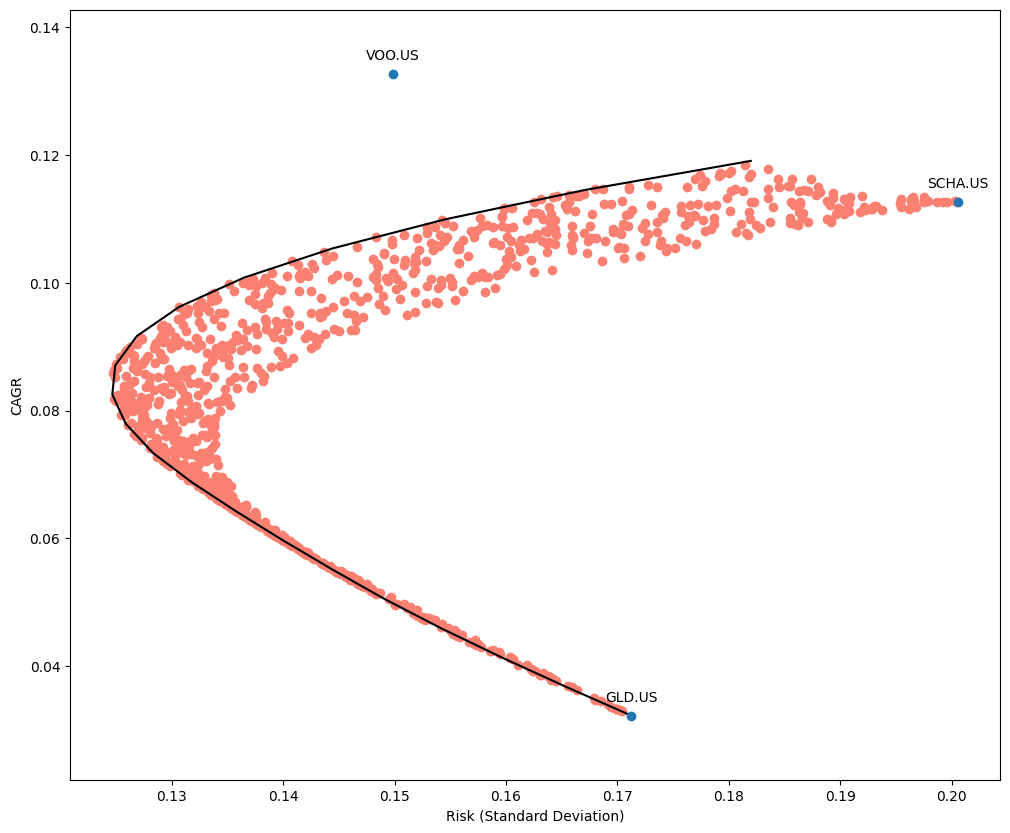

In [4]:
assets = ["VOO.US", "GLD.US", "SCHA.US"]
curr = "USD"

x_2 = ok.EfficientFrontierReb(
    assets=assets,
    first_date="2004-10",
    last_date="2020-10",
    ccy=curr,
    bounds=((0, 0.3), (0, 1), (0, 1)),  # add bounds    
    verbose=False,
)

df_2 = x_2.ef_points

monte_carlo_2 = x_2.get_monte_carlo(n=1000)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot Monte Carlo simulation and the Eficient Frontier
ax.plot(df_2.Risk, df_2.CAGR, color="black")
ax.scatter(monte_carlo_2.Risk, monte_carlo_2.CAGR, color="salmon")  # draw the random portfolios risk-return points

# Plot the assets
x_2.plot_assets(kind="cagr")

ax.set_xlabel("Risk (Standard Deviation)")
ax.set_ylabel("CAGR");

## Problem with optimization for 2 assets

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
ef = ok.EfficientFrontierReb(['SPY.US', 'MCFTR.INDX'], ccy='RUB', last_date='2025-03', bounds=None)

In [10]:
ef = ok.EfficientFrontierReb(['SPY.US', 'GLD.US'], ccy='USD', last_date='2020-10', bounds=None)

<Axes: >

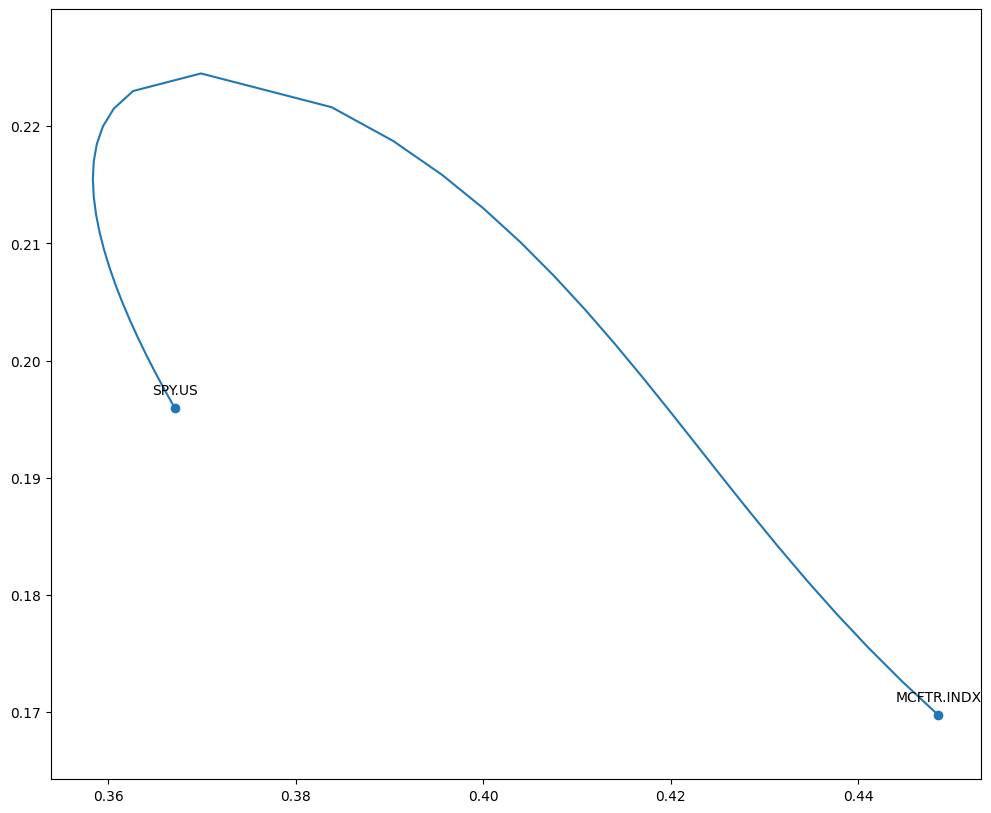

In [7]:
df1_reb_year = ef.ef_points

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the Efficient Frontiers
ax.plot(df1_reb_year.Risk, df1_reb_year.CAGR, label="Annually rebalanced")
# ax.plot(df1_not_reb.Risk, df1_not_reb.CAGR, label="Not rebalanced")

# Plot the assets
ef.plot_assets(kind="cagr")


In [13]:
left_point = ef._min_ratio_asset_left_to_max_cagr
print(left_point)

{'min_asset_cagr': np.float64(0.1959425614987127), 'ticker_with_smallest_ratio': 'SPY.US', 'list_position': 0}


In [4]:
df1_reb_year

,Risk,CAGR,SPY.US,MCFTR.INDX
0,0.367104,0.195943,1.000000,0.000000
1,0.366050,0.197446,0.986791,0.013209
2,0.365040,0.198949,0.973203,0.026797
3,0.364077,0.200452,0.959206,0.040794
4,0.363164,0.201955,0.944753,0.055247
5,0.362307,0.203458,0.929812,0.070188
6,0.361511,0.204962,0.914327,0.085673
7,0.360781,0.206465,0.898236,0.101764
8,0.360125,0.207968,0.881467,0.118533
9,0.359553,0.209471,0.863927,0.136073


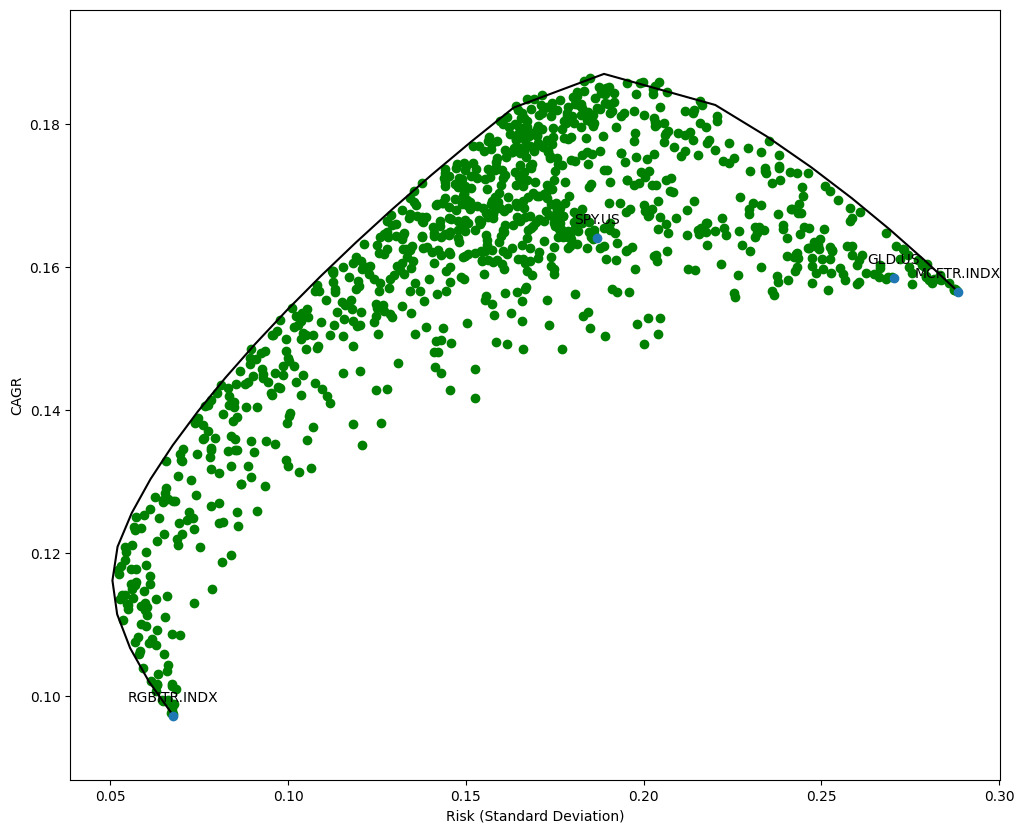

In [4]:
ls_m = ["SPY.US", "GLD.US", "RGBITR.INDX", "MCFTR.INDX"]
curr_rub = "RUB"



x = ok.EfficientFrontierReb(
    assets=ls_m,
    first_date="2005-01",
    last_date="2020-11",
    ccy=curr_rub,
    rebalancing_period="year",  # set rebalancing period to one year

    n_points=20,
)

df1_reb_year = x.ef_points

monte_carlo = x.get_monte_carlo(n=1000)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot Monte Carlo simulation and the Eficient Frontier
ax.plot(df1_reb_year.Risk, df1_reb_year.CAGR, color="black")
ax.scatter(monte_carlo.Risk, monte_carlo.CAGR, color="green")  # draw the random portfolios risk-return points

# Plot the assets
x.plot_assets(kind="cagr")

ax.set_xlabel("Risk (Standard Deviation)")
ax.set_ylabel("CAGR");

## Proplem with optimiation 3 assets

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

<Axes: >

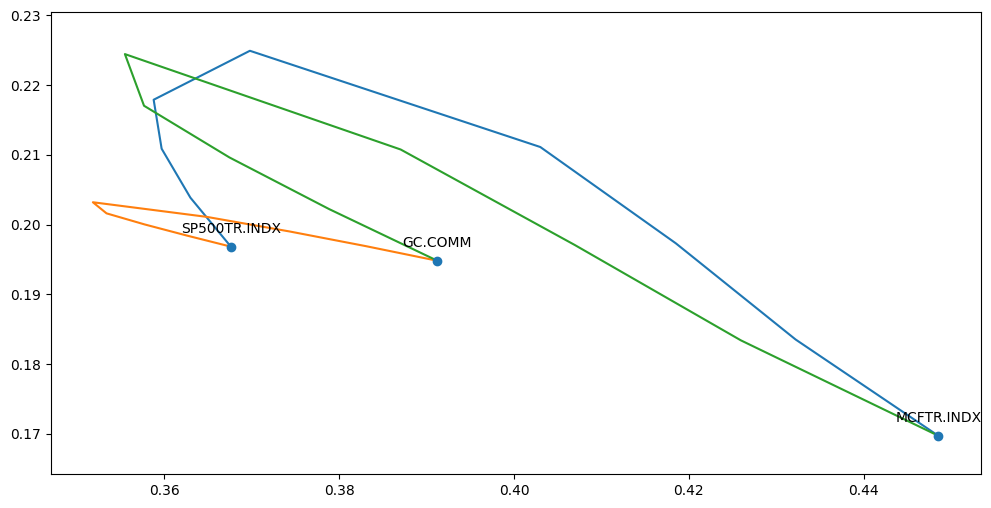

In [2]:
ef = ok.EfficientFrontierReb(['SP500TR.INDX', 'MCFTR.INDX', 'GC.COMM'], ccy='RUB', n_points=5, first_date='1997-10', last_date='2025-03', full_frontier=True)
ef.rebalancing_period = "year"

ef.plot_pair_ef()

In [15]:
ef.first_date

Timestamp('1997-10-01 00:00:00')

<Axes: >

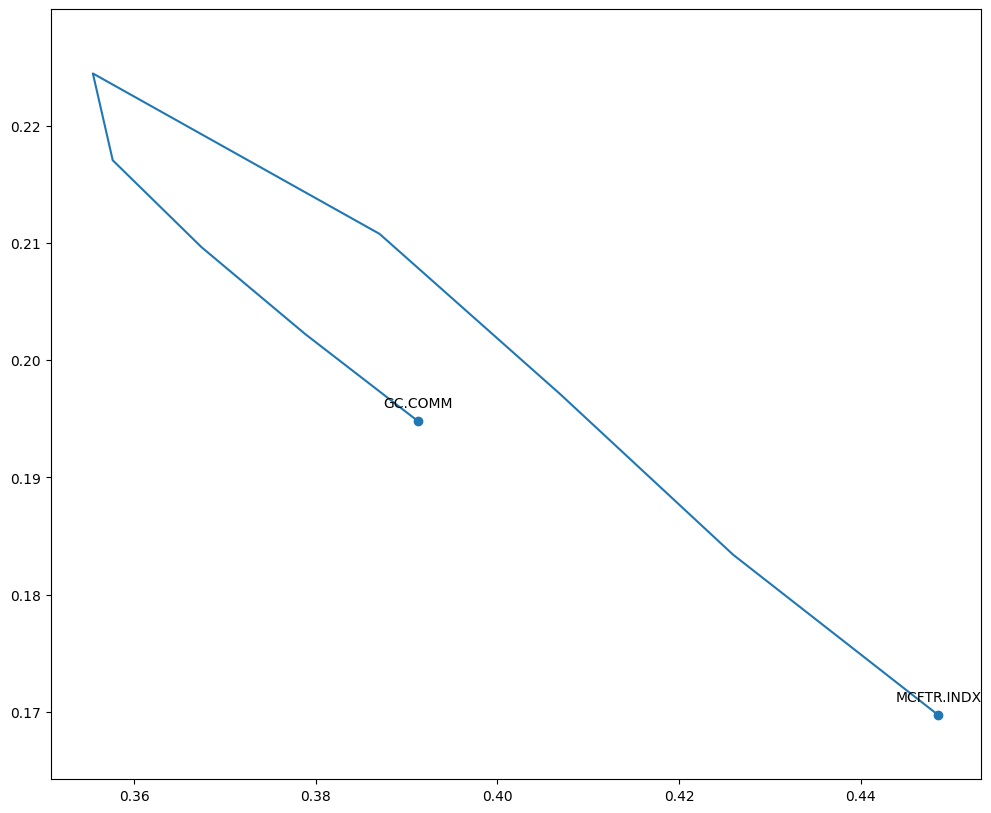

In [4]:
ef1 = ok.EfficientFrontierReb(['MCFTR.INDX', 'GC.COMM'], ccy='RUB', n_points=5, first_date='1997-10', last_date='2025-03', full_frontier=True)
ef1.rebalancing_period = "year"
df1_reb_year = ef1.ef_points

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the Efficient Frontiers
ax.plot(df1_reb_year.Risk, df1_reb_year.CAGR, label="Annually rebalanced")

# Plot the assets
ef1.plot_assets(kind="cagr")

<Axes: >

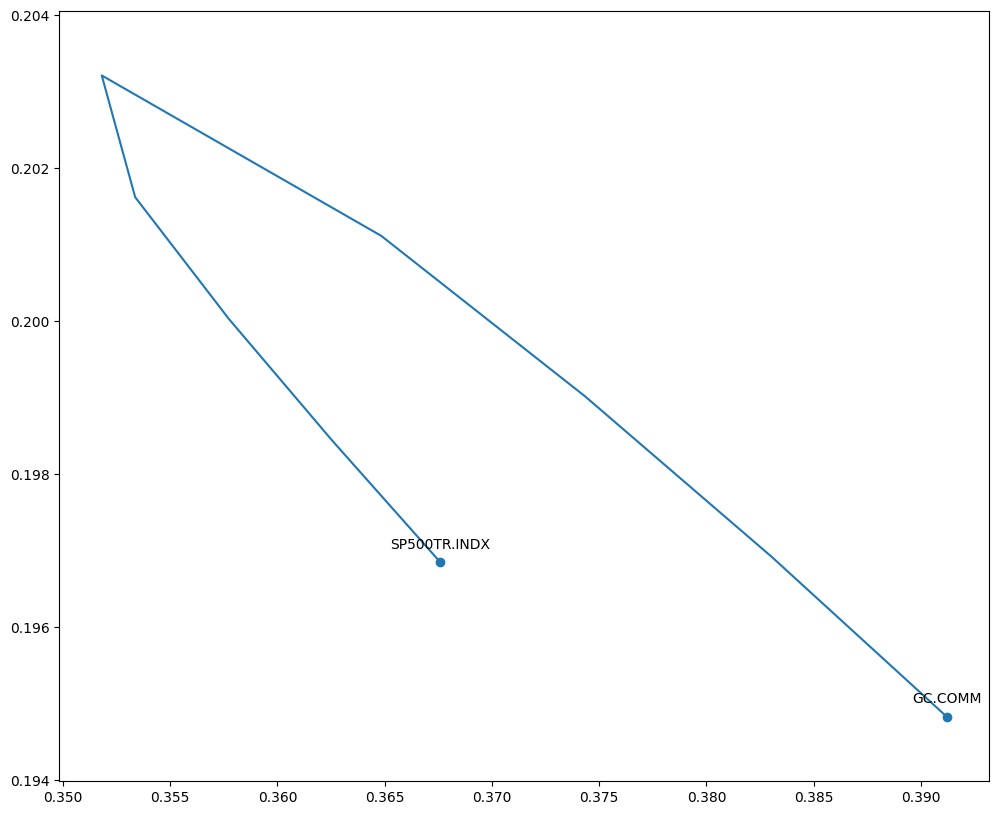

In [7]:
ef2 = ok.EfficientFrontierReb(['SP500TR.INDX', 'GC.COMM'], ccy='RUB', n_points=5, first_date='1997-10', last_date='2025-03', full_frontier=True)
ef2.rebalancing_period = "year"
df2_reb_year = ef2.ef_points

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the Efficient Frontiers
ax.plot(df2_reb_year.Risk, df2_reb_year.CAGR, label="Annually rebalanced")

# Plot the assets
ef2.plot_assets(kind="cagr")